# Lightweight PINN — Non-Radially Symmetric PDE

This notebook implements a lightweight **Physics-Informed Neural Network (PINN)** to solve a **non-radially symmetric Poisson-type PDE** on the unit disk.

The governing equation is:

$u_{xx} + u_{yy} = x + e^x - \sin(y), \quad (x, y) \in \{x^2 + y^2 < 1\}$

with Dirichlet boundary condition:

$u|_{r=1} = 0.$

Unlike the radially symmetric case, the right-hand side $f(x, y)$ here depends separately on both $x$ and $y$, breaking the symmetry of the domain.  
This setup allows us to test whether a compact, fully-connected neural network can approximate solutions that vary in both spatial directions without relying on polar simplifications.

The notebook proceeds through:
- **Setup:** imports, reproducibility, device selection, and sampling functions for domain and boundary points.  
- **Model:** definition of a small multilayer perceptron (MLP) used as the PINN’s trainable function $u_\theta(x, y)$.  
- **Training:** optimization using PDE and boundary losses.  
- **Evaluation:** visual and numerical comparison of predicted vs analytical solutions.


## Setup


This cell prepares the problem and sampling functions.

- Fixes random seeds for reproducibility across Python, NumPy, and PyTorch.  
- Selects the device (cpu) and sets data type to float32.  
- Defines the PDE right-hand side  
  $f(x, y) = x + e^x - \sin(y)$.  
- boundary_points() samples random points on the unit circle ($x^2 + y^2 = 1$).  
- interior_points() uses rejection sampling to draw points uniformly inside the unit disk ($x^2 + y^2 < 1$).  

These points form the training data for enforcing both PDE and boundary conditions.


In [9]:
# Setup: imports, reproducibility, device selection and simple problem helpers
import random, numpy as np, torch, torch.nn as nn
import matplotlib.pyplot as plt

# Fix randomness for reproducible runs (seed affects sampling and training init)
seed = 1234
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
# Device and dtype selection (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print("Device:", device)

# PDE right-hand-side f(x,y) = x + e^x - sin(y). We expect torch tensors as inputs.
# The function returns a tensor with same shape as x/y (elementwise).
def f_xy(x,y): return x + torch.exp(x) - torch.sin(y)

# Boundary sampling on the unit circle: return (n_b,2) tensor on selected device/dtype
def boundary_points(n_b=512):
    # sample angles uniformly and return points on the unit circle
    theta = 2*np.pi*np.random.rand(n_b)
    xb, yb = np.cos(theta), np.sin(theta)
    return torch.tensor(np.c_[xb, yb], dtype=dtype, device=device)

# Interior sampling inside unit disk using rejection sampling from square [-1,1]^2
def interior_points(n_i=5000):
    # use rejection sampling to uniformly sample inside the unit disk
    pts = []
    need = n_i
    while need > 0:
        chunk = int(1.5*need)
        xs = 2*np.random.rand(chunk)-1
        ys = 2*np.random.rand(chunk)-1
        mask = xs*xs + ys*ys < 1.0
        keep = np.c_[xs[mask], ys[mask]]
        # take at most `need` points from this chunk
        pts.append(keep[:need])
        need -= keep[:need].shape[0]
    # Stack and return as torch tensor on device
    return torch.tensor(np.vstack(pts), dtype=dtype, device=device)

Device: cpu


## Model 


The PINN uses a compact feedforward neural network TinyMLP to approximate  
$u_\theta(x, y)$ — the solution of the PDE.

- Architecture:  
  A fully connected MLP mapping $(x, y) \in \mathbb{R}^2$ to a scalar $u \in \mathbb{R}$.  
  Structure: 2 → hidden → ... → 1, with configurable depth and hidden size.

- Activation:  
  Uses Tanh nonlinearities for smoothness and good gradient behavior.

- Initialization:  
  Each linear layer is initialized with Xavier uniform weights and zero bias to stabilize early training.

- Implementation details:  
  - Built as nn.Sequential for simplicity.  
  - Forward pass applies the network to each coordinate pair $(x, y)$ independently.  
  - Default configuration uses 4 layers with 64 hidden units (depth=4, hidden=64).

The total parameter count (~12k) makes this model lightweight but expressive enough to capture non-radial solution features.


In [10]:
# Tiny MLP used as the PINN's trainable function approximator
# This small fully-connected network maps (x,y) in R^2 to scalar u(x,y).
class TinyMLP(nn.Module):
    def __init__(self, hidden=64, depth=4, act=nn.Tanh):
        super().__init__()
        # Build a small fully-connected network: 2 -> hidden -> ... -> 1
        layers = [nn.Linear(2, hidden), act()]
        for _ in range(depth-1):
            layers += [nn.Linear(hidden, hidden), act()]
        layers += [nn.Linear(hidden, 1)]
        self.net = nn.Sequential(*layers)
        # Initialize linear layers for stable training (Xavier + zero bias)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, xy):
        """Forward pass expects an (N,2) tensor and returns (N,1) output.
        The network operates pointwise on the batch of coordinates.
        """
        return self.net(xy)

# Instantiate model and move to device
model = TinyMLP().to(device)
print("Params:", sum(p.numel() for p in model.parameters()))

Params: 12737


## Autograd Laplacian + batched loss


This cell defines how the PDE residual and training losses are computed.

laplacian_autograd(xy) computes $\Delta u = u_{xx} + u_{yy}$ using PyTorch autograd.

Get $u(x,y)$ from the model, then its gradient $g=\nabla_{x,y}u$ via autograd with create_graph=True so second derivatives are allowed.

Differentiate the $x$ component of $g$ w.r.t. $x$ to obtain $u_{xx}$, and the $y$ component w.r.t. $y$ to obtain $u_{yy}$.

Return $u_{xx}+u_{yy}$.

pde_residual(xy_batch) returns the residual $r=\Delta u - f(x,y)$ evaluated at a batch of interior points.
Inputs are cloned with requires_grad=True so derivatives w.r.t. $(x,y)$ can be taken. Shapes are adjusted so $r$ and $u$ are $(N,1)$.

loss_fn_batched(xy_i, xy_b, batch_i, w_pde, w_bc) splits the interior collocation set into random minibatches to control memory.
For each interior minibatch $i$, it aggregates mean squared residual $\mathbb{E}[r^2]$.
The boundary loss enforces the Dirichlet condition $u=0$ on the unit circle via $\mathbb{E}\big[u(x_b,y_b)^2\big]$.
The total loss is
$L = w_{\mathrm{pde}} \cdot L_{\mathrm{pde}} + w_{\mathrm{bc}} \cdot L_{\mathrm{bc}}$.
Detached copies of component losses are returned for logging.

In [11]:
# Autograd-based Laplacian: compute u_xx + u_yy by differentiating w.r.t. input coordinates
def laplacian_autograd(u, xy):
    # g is the gradient [u_x, u_y] with shape (N,2)
    # create_graph=True so higher-order derivatives can be computed from g
    g = torch.autograd.grad(u, xy, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    # second derivatives: differentiate components of g w.r.t. inputs
    # uxx is the derivative of g[...,0] w.r.t. x (component 0)
    uxx = torch.autograd.grad(g[...,0:1], xy, torch.ones_like(g[...,0:1]), create_graph=True, retain_graph=True)[0][...,0:1]
    # uyy is the derivative of g[...,1] w.r.t. y (component 1)
    uyy = torch.autograd.grad(g[...,1:2], xy, torch.ones_like(g[...,1:2]), create_graph=True, retain_graph=True)[0][...,1:2]
    return uxx + uyy

def pde_residual(xy_batch):
    """Compute PDE residual r = Δu - f at a batch of input points xy_batch.

    xy_batch: (N,2) tensor. Returns (residual (N,1), u (N,1)).
    """
    # Ensure inputs require gradients for autograd to compute derivatives w.r.t. x,y
    xy = xy_batch.clone().requires_grad_(True)
    x, y = xy[...,0:1], xy[...,1:2]
    # Forward pass through the network to obtain u(x,y) as (N,1)
    u = model(xy)
    # Compute Laplacian via autograd (u_xx + u_yy)
    lap = laplacian_autograd(u, xy)
    # Evaluate RHS and ensure it has shape (N,1) for broadcasting consistency
    rhs = f_xy(x,y)
    if rhs.dim()==1: rhs = rhs.unsqueeze(-1)
    # Residual r(x,y) = Δu - f(x,y)
    return lap - rhs, u

def loss_fn_batched(xy_i, xy_b, batch_i=2048, w_pde=1.0, w_bc=1.0):
    """Compute PDE loss by splitting interior collocation points into minibatches.

    Returns: (total_loss, loss_pde, loss_bc) where loss_pde/loss_bc are detached tensors for logging.
    """
    n = xy_i.shape[0]
    idx = torch.randperm(n, device=device)
    total_pde = 0.0; nb = 0
    for s in range(0, n, batch_i):
        b = idx[s:s+batch_i]
        res, _ = pde_residual(xy_i[b])
        total_pde += (res**2).mean()
        nb += 1
    loss_pde = total_pde / nb
    # Boundary loss: enforce u=0 on the sampled boundary points (Dirichlet)
    loss_bc = (model(xy_b)**2).mean()
    return w_pde*loss_pde + w_bc*loss_bc, loss_pde.detach(), loss_bc.detach()

## Data

In [12]:
# Sample collocation points for training and validation
# Interior collocation points used to enforce PDE in the disk interior
xy_i = interior_points(8000)
# Boundary points used to enforce Dirichlet condition u=0 on r=1
xy_b = boundary_points(1024)
print("Interior:", xy_i.shape, "Boundary:", xy_b.shape)

# Small held-out validation sets for quick evaluation during/after training
xy_i_val = interior_points(3000)
xy_b_val = boundary_points(512)

Interior: torch.Size([8000, 2]) Boundary: torch.Size([1024, 2])


## Training

This cell runs a two-stage optimization routine.

Adam phase
• Optimizer: Adam with learning rate $2\times 10^{-3}$.
• Loop for EPOCHS iterations. Each step: zero grads → compute total, pde, bc via loss_fn_batched → backpropagate → optimizer step.
• History dict stores epoch, total, pde, and bc losses for later plotting.
• Printing every PRINT_EVERY iterations provides quick feedback on progress.

Optional L-BFGS refinement
• If USE_LBFGS is True, switch to torch.optim.LBFGS with a small max_iter (e.g., 80) and strong Wolfe line search.
• Define a closure that zeroes grads, recomputes the total loss on a fresh random interior batch, backprops, and returns the scalar loss.
• L-BFGS then performs quasi-Newton updates to polish the solution reached by Adam.

In [13]:
# Short Adam training run to get the network into a reasonable solution
adam = torch.optim.Adam(model.parameters(), lr=2e-3)
# History dict to record losses for plotting
history = {"epoch": [], "total": [], "pde": [], "bc": []}

# Training hyperparameters
EPOCHS = 2000
PRINT_EVERY = 200
BATCH_I = 4096

for ep in range(1, EPOCHS+1):
    # Zero gradients, compute loss, backprop and take an optimizer step
    adam.zero_grad()
    total, pde_l, bc_l = loss_fn_batched(xy_i, xy_b, batch_i=BATCH_I)
    total.backward(); adam.step()
    # Log and optionally print selected epochs for monitoring progress
    if ep % PRINT_EVERY == 0 or ep == 1:
        history["epoch"].append(ep)
        history["total"].append(float(total.detach().cpu()))
        history["pde"].append(float(pde_l.cpu()))
        history["bc"].append(float(bc_l.cpu()))
        print(f"[Adam] {ep:4d}  loss={float(total):.3e}  pde={float(pde_l):.3e}  bc={float(bc_l):.3e}")
        
        
USE_LBFGS = True
if USE_LBFGS:
    lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=80, line_search_fn="strong_wolfe")
    def closure():
        lbfgs.zero_grad()
        total, _, _ = loss_fn_batched(xy_i, xy_b, batch_i=BATCH_I)
        total.backward()
        return total
    print("LBFGS refinement…")
    lbfgs.step(closure)


[Adam]    1  loss=2.584e+00  pde=2.562e+00  bc=2.168e-02
[Adam]  200  loss=7.562e-04  pde=6.755e-04  bc=8.072e-05
[Adam]  200  loss=7.562e-04  pde=6.755e-04  bc=8.072e-05
[Adam]  400  loss=2.379e-04  pde=2.354e-04  bc=2.429e-06
[Adam]  400  loss=2.379e-04  pde=2.354e-04  bc=2.429e-06
[Adam]  600  loss=6.230e-03  pde=1.090e-03  bc=5.141e-03
[Adam]  600  loss=6.230e-03  pde=1.090e-03  bc=5.141e-03
[Adam]  800  loss=2.035e-03  pde=9.116e-05  bc=1.944e-03
[Adam]  800  loss=2.035e-03  pde=9.116e-05  bc=1.944e-03
[Adam] 1000  loss=6.636e-05  pde=5.202e-05  bc=1.434e-05
[Adam] 1000  loss=6.636e-05  pde=5.202e-05  bc=1.434e-05
[Adam] 1200  loss=3.531e-05  pde=3.372e-05  bc=1.590e-06
[Adam] 1200  loss=3.531e-05  pde=3.372e-05  bc=1.590e-06
[Adam] 1400  loss=8.948e-04  pde=8.174e-04  bc=7.734e-05
[Adam] 1400  loss=8.948e-04  pde=8.174e-04  bc=7.734e-05
[Adam] 1600  loss=2.858e-05  pde=2.697e-05  bc=1.608e-06
[Adam] 1600  loss=2.858e-05  pde=2.697e-05  bc=1.608e-06
[Adam] 1800  loss=1.060e-04  pd

## Loss Curves

This cell visualizes how the PINN losses evolve during training.

- The blue line shows the **total loss**, combining both PDE and boundary terms.  
- The orange line represents the mean squared PDE residual $\lVert \Delta u - f \rVert^2$.  
- The green line represents the boundary loss $\lVert u(x_b, y_b)\rVert^2$ enforcing $u=0$ on the unit circle.

Losses are plotted on a logarithmic scale to capture values across several magnitudes.  
All three curves generally decrease over epochs, showing that both the PDE and boundary conditions are being satisfied progressively, however they are noticably much more volatile compared to the loss curves of our previouos models.


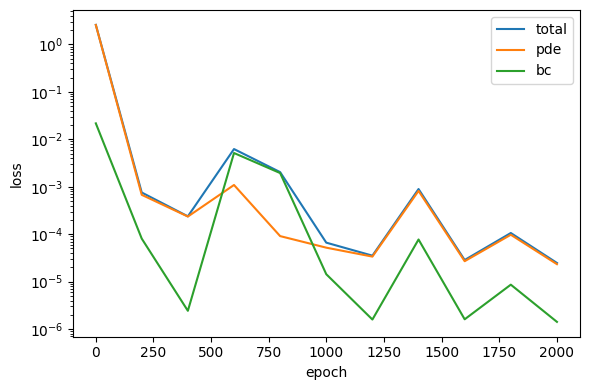

In [14]:
# Plot training curves if any history was recorded
if len(history["epoch"])>0:
    plt.figure(figsize=(6,4))
    # total: combined PDE + BC loss; pde: interior residual loss; bc: boundary loss
    plt.plot(history["epoch"], history["total"], label="total")
    plt.plot(history["epoch"], history["pde"], label="pde")
    plt.plot(history["epoch"], history["bc"], label="bc")
    plt.yscale("log"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("No history to plot.")

## Evaluation Metrics

This section evaluates the trained model on unseen (validation) points.

- PDE residual RMSE measures how well the network satisfies the PDE:
$$\text{RMSE}_{\text{PDE}} = \sqrt{\mathbb{E}[(\Delta u - f)^2]}$$
- Boundary RMSE measures how well the network enforces the Dirichlet condition:
$$\text{RMSE}_{\text{BC}} = \sqrt{\mathbb{E}[u(x_b, y_b)^2]}$$

Interpretation:
- Both values are small, but not as small as our previous models.
- The PDE error is slightly higher than the boundary error, which is expected because interior derivatives are harder to optimize.  


In [15]:
# PDE residual RMSE on held-out interior (NO no_grad here — needs autograd)
def residual_rmse_on(xy_val, batch=2048):
    vals = []
    for i in range(0, xy_val.shape[0], batch):
        # each chunk must require grad so we can compute second derivatives
        chunk = xy_val[i:i+batch].clone().requires_grad_(True)
        u = model(chunk)
        # first derivatives [u_x, u_y]
        g = torch.autograd.grad(u, chunk, torch.ones_like(u), create_graph=True)[0]
        # second derivatives u_xx and u_yy (take care to select correct components)
        uxx = torch.autograd.grad(g[...,0:1], chunk, torch.ones_like(g[...,0:1]), create_graph=True)[0][...,0:1]
        uyy = torch.autograd.grad(g[...,1:2], chunk, torch.ones_like(g[...,1:2]), create_graph=True)[0][...,1:2]
        lap = uxx + uyy
        x, y = chunk[...,0:1], chunk[...,1:2]
        # RHS must be shaped (N,1) to subtract from laplacian
        rhs = f_xy(x,y).view(-1,1)
        vals.append((lap - rhs).detach().cpu().numpy())
    res = np.concatenate(vals, axis=0).reshape(-1)
    return float(np.sqrt(np.mean(res**2)))

pde_RMSE = residual_rmse_on(xy_i_val, batch=1024)

# Boundary RMSE can use no_grad since model outputs are used directly (no derivatives)
with torch.no_grad():
    bc_vals = model(xy_b_val).cpu().numpy().reshape(-1)
bc_RMSE = float(np.sqrt(np.mean(bc_vals**2)))

print("Metrics (validation):")
print(f"  PDE residual RMSE (interior): {pde_RMSE:.3e}")
print(f"  Boundary RMSE (Dirichlet):     {bc_RMSE:.3e}")

Metrics (validation):
  PDE residual RMSE (interior): 2.913e-03
  Boundary RMSE (Dirichlet):     1.050e-03


## Visualization 

This section visualizes the trained PINN solution and its residual error across the unit disk.

- disk_grid(n=121) builds a square grid and masks out points outside the unit circle $(x^2 + y^2 < 1)$.  
  The resulting points are used for plotting predictions and evaluating residuals.
- plot_field() displays scalar fields defined on the disk (e.g., $u(x,y)$ or $|\Delta u - f|$) with a circular outline showing the boundary.
- residual_on_grid() computes the PDE residual on a dense grid by applying autograd to evaluate $u_{xx}$ and $u_{yy}$ at each location.

The first plot shows the predicted solution $u(x,y)$ on a coarse grid.  

The second plot displays the residual magnitude $|\Delta u - f|$ on the same grid.  
Residuals are low (mostly below $0.015$) but show some higher spots of loss.

A histogram of residual magnitudes further confirms that most residual values are near zero.


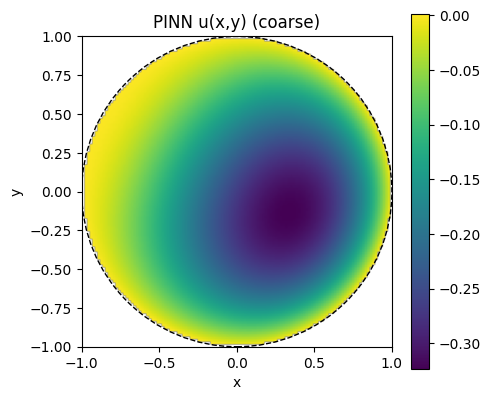

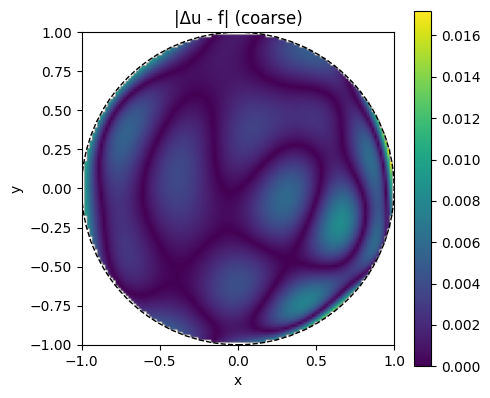

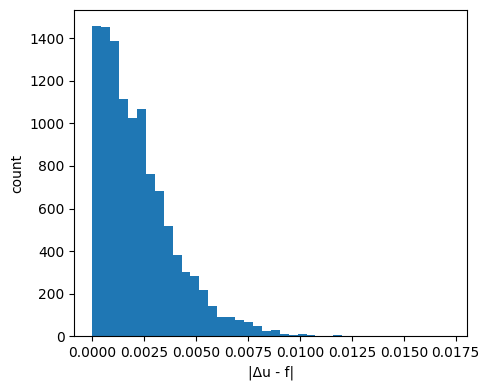

In [16]:
def disk_grid(n=121):
    # Create a square grid and mask points outside the unit disk
    xs = np.linspace(-1,1,n); ys = np.linspace(-1,1,n)
    XX, YY = np.meshgrid(xs, ys, indexing="xy")
    mask = (XX**2 + YY**2) < 1.0
    pts = np.stack([XX[mask], YY[mask]], axis=1)
    # Return grid arrays plus a torch tensor of masked points on correct device/dtype
    return xs, ys, mask, XX, YY, torch.tensor(pts, dtype=dtype, device=device)

def plot_field(Z, XX, YY, mask, title):
    # Helper to plot a field defined only inside the disk (masked outside)
    Zplot = np.full_like(XX, np.nan, dtype=float); Zplot[mask] = Z
    plt.figure(figsize=(5,4.3))
    im = plt.imshow(Zplot, extent=[XX.min(), XX.max(), YY.min(), YY.max()], origin="lower")
    plt.colorbar(im); plt.title(title); plt.xlabel("x"); plt.ylabel("y")
    circle = plt.Circle((0,0), 1.0, fill=False, linestyle="--"); plt.gca().add_patch(circle)
    plt.tight_layout(); plt.show()

# Build grid and evaluate model predictions on masked points
xs, ys, mask, XX, YY, pts_t = disk_grid(121)
with torch.no_grad():
    up = model(pts_t).cpu().numpy().reshape(-1)
plot_field(up, XX, YY, mask, "PINN u(x,y) (coarse)")

# Residuals on grid (needs autograd; compute in batches)
def residual_on_grid(pts_t, batch=4096):
    vals = []
    for i in range(0, pts_t.shape[0], batch):
        # each chunk must require grad so autograd can produce second derivatives
        chunk = pts_t[i:i+batch].clone().requires_grad_(True)
        u = model(chunk)
        g = torch.autograd.grad(u, chunk, torch.ones_like(u), create_graph=True)[0]
        uxx = torch.autograd.grad(g[...,0:1], chunk, torch.ones_like(g[...,0:1]), create_graph=True)[0][...,0:1]
        uyy = torch.autograd.grad(g[...,1:2], chunk, torch.ones_like(g[...,1:2]), create_graph=True)[0][...,1:2]
        lap = uxx + uyy
        x, y = chunk[...,0:1], chunk[...,1:2]
        rhs = f_xy(x,y).view(-1,1)
        vals.append((lap - rhs).detach().cpu().numpy().reshape(-1))
    return np.concatenate(vals, axis=0)

res = residual_on_grid(pts_t, batch=4096)
plot_field(np.abs(res), XX, YY, mask, "|Δu - f| (coarse)")
plt.figure(figsize=(5,4)); plt.hist(np.abs(res), bins=40); plt.xlabel("|Δu - f|"); plt.ylabel("count"); plt.tight_layout(); plt.show()